# SETUP

## Check environment

In [1]:
USE_GPU = False

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
%matplotlib widget

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1760963382.364232 2587581 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760963382.371325 2587581 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760963382.387791 2587581 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760963382.387806 2587581 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760963382.387807 2587581 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760963382.387809 2587581 computation_placer.cc:177] computation placer already registered. Please check linka

Using CPU to train
2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# CMAQ DATA

## Load cmaq data

### Raw data

In [4]:
df_cmaq_raw = pd.read_csv(conf["dataset"]["cmaq_with_no"]["file_dir"])
df_cmaq_raw

,Datetime,PM25,PM10,O3,SO2,NO2,Station,NO
0,2022-01-01 07:00:00,4.878905,14.811759,0.097426,0.000165,0.002692,212,NaN
1,2022-01-01 08:00:00,6.771205,21.716939,0.076096,0.000226,0.003342,212,NaN
2,2022-01-01 09:00:00,7.170122,23.216116,0.066343,0.000253,0.002588,212,NaN
3,2022-01-01 10:00:00,7.128181,23.774334,0.056412,0.000227,0.001720,212,NaN
4,2022-01-01 11:00:00,6.519380,21.588541,0.048995,0.000167,0.001217,212,NaN
...,...,...,...,...,...,...,...,...
52327,2022-12-31 01:00:00,16.292831,54.826836,0.026622,0.000073,0.003449,214,0.000014
52328,2022-12-31 02:00:00,16.437155,55.074300,0.026347,0.000073,0.003513,214,0.000014
52329,2022-12-31 03:00:00,16.222981,55.691070,0.026656,0.000075,0.003364,214,0.000014
52330,2022-12-31 04:00:00,15.969438,54.991848,0.026848,0.000078,0.003203,214,0.000014


### Handle metadata

In [5]:
# Set datetime
df_cmaq_raw = df_cmaq_raw.assign(Datetime=pd.to_datetime(df_cmaq_raw["Datetime"]))

# Rename columns
df_cmaq_raw = df_cmaq_raw.rename(columns={name: f"{name.lower()}" for name in df_cmaq_raw.columns})

# Set index
df_cmaq_raw = df_cmaq_raw.set_index("datetime")

# Print
df_cmaq_raw

,pm25,pm10,o3,so2,no2,station,no
datetime,,,,,,,
2022-01-01 07:00:00,4.878905,14.811759,0.097426,0.000165,0.002692,212,NaN
2022-01-01 08:00:00,6.771205,21.716939,0.076096,0.000226,0.003342,212,NaN
2022-01-01 09:00:00,7.170122,23.216116,0.066343,0.000253,0.002588,212,NaN
2022-01-01 10:00:00,7.128181,23.774334,0.056412,0.000227,0.001720,212,NaN
2022-01-01 11:00:00,6.519380,21.588541,0.048995,0.000167,0.001217,212,NaN
...,...,...,...,...,...,...,...
2022-12-31 01:00:00,16.292831,54.826836,0.026622,0.000073,0.003449,214,0.000014
2022-12-31 02:00:00,16.437155,55.074300,0.026347,0.000073,0.003513,214,0.000014
2022-12-31 03:00:00,16.222981,55.691070,0.026656,0.000075,0.003364,214,0.000014


## EDA

### Statistic

In [6]:
df_cmaq_stat = df_cmaq_raw.drop(columns=["station"]).describe()
df_cmaq_stat

,pm25,pm10,o3,so2,no2,no
count,52332.000000,52332.000000,52332.000000,5.233200e+04,52332.000000,4.469500e+04
mean,19.373324,55.656308,0.028526,5.530125e-04,0.005339,1.505774e-04
std,16.917802,47.628885,0.007503,9.868932e-04,0.006821,1.653540e-04
min,0.068628,0.089172,0.014453,3.160000e-09,0.000017,6.477872e-08
25%,9.758437,28.219765,0.025730,1.004007e-04,0.000934,3.696420e-05
50%,13.706406,44.558864,0.027195,2.344415e-04,0.002718,9.456088e-05
75%,23.379823,65.914449,0.028940,5.746160e-04,0.007005,2.093186e-04
max,294.028215,920.479352,0.119494,1.995822e-02,0.073905,1.297282e-03


### Check null

In [7]:
df_cmaq_raw.isnull().sum()

pm25          0
pm10          0
o3            0
so2           0
no2           0
station       0
no         7637
dtype: int64

### Correlation matrix

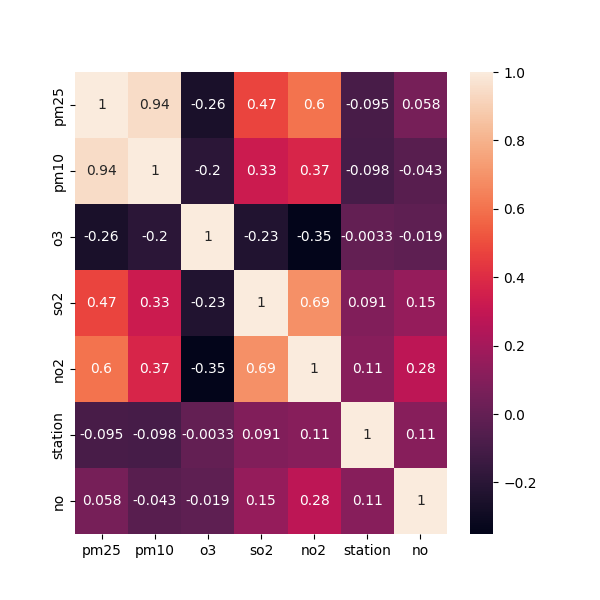

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(df_cmaq_raw.corr(), annot=True, ax=ax)
plt.show()

### Statistic by station

In [9]:
stations = sorted(df_cmaq_raw["station"].unique())
for station in stations:
    df_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]
    print(f"CURRENT STATION = {station}, RECORDS = {len(df_current_station)}")
    print(f"Missing NO: {df_current_station['no'].isnull().sum()}")

CURRENT STATION = 201, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 211, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 212, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 213, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 214, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 215, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 216, RECORDS = 7476
Missing NO: 1091


## Preprocessing

### Fill "NO" column


Handling for station 201



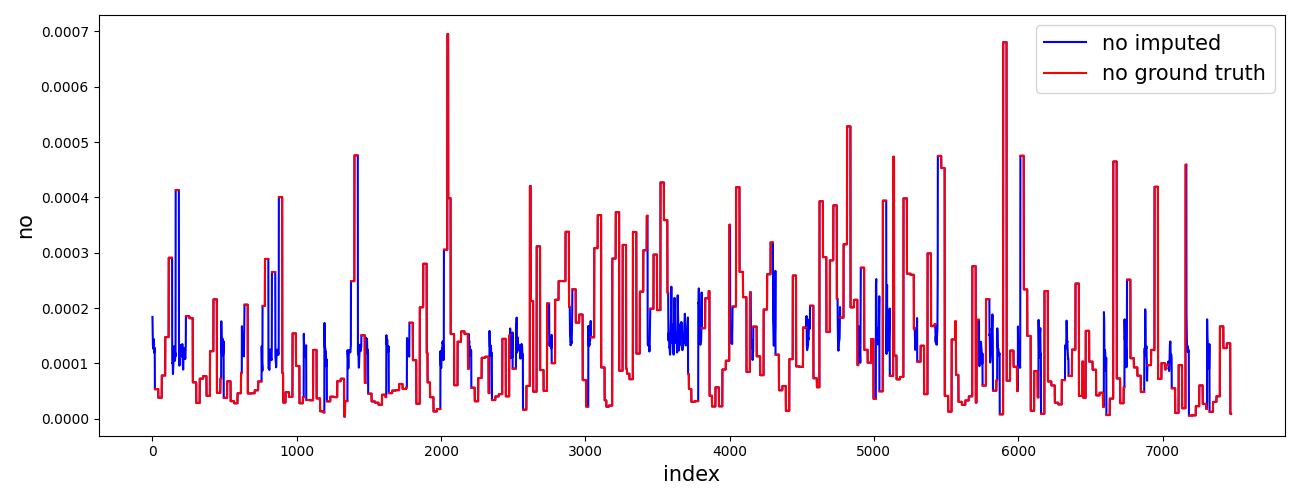


Handling for station 211



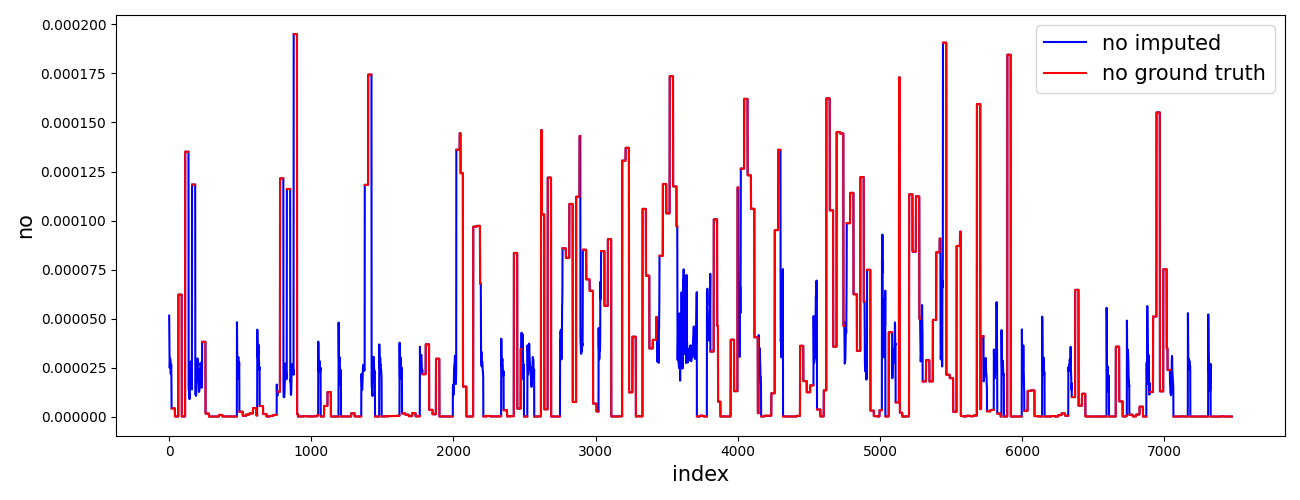


Handling for station 212



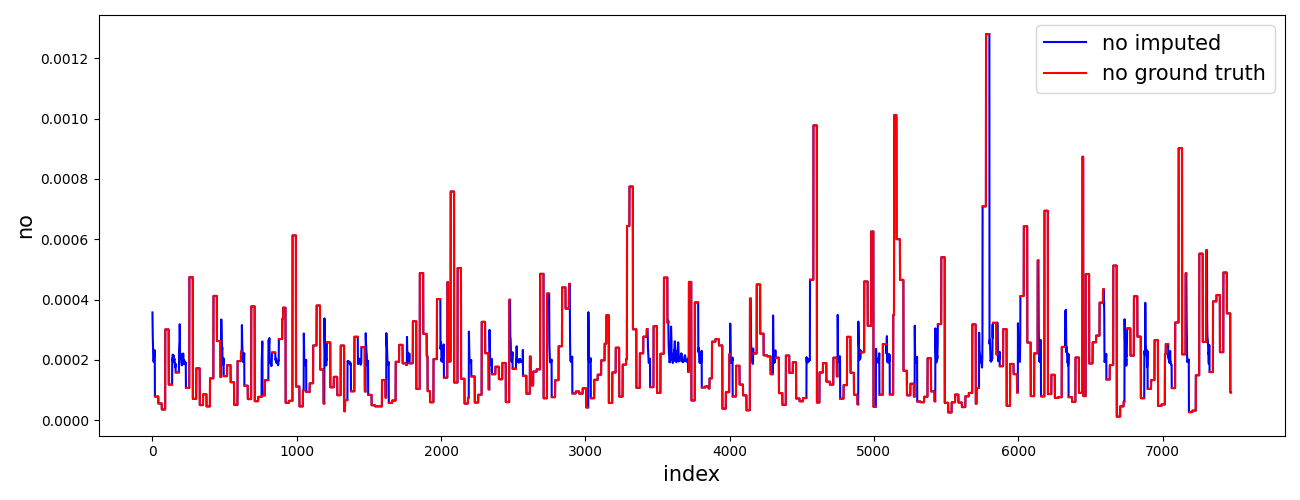


Handling for station 213



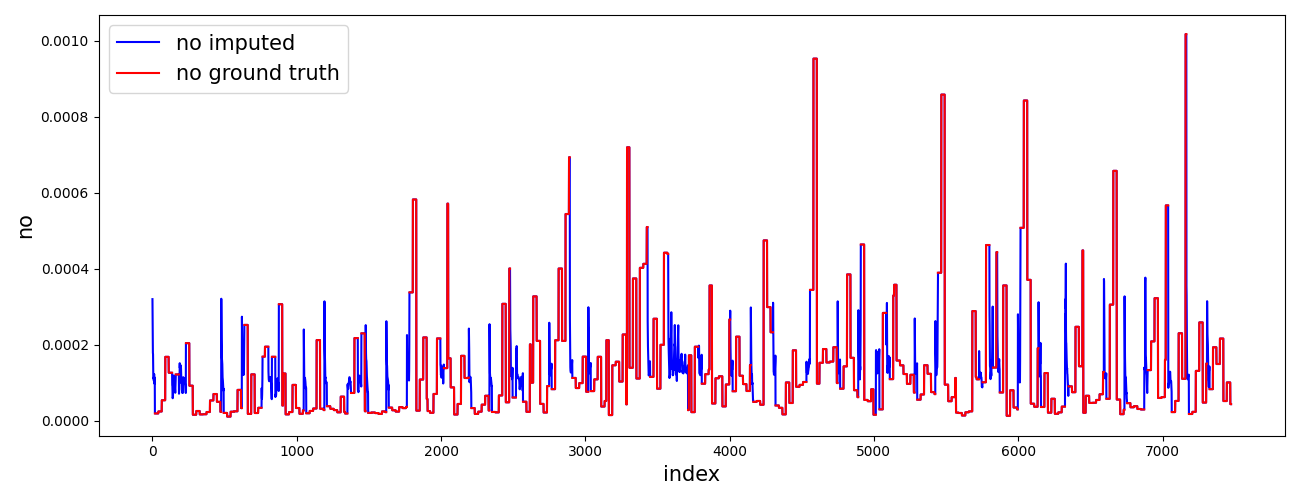


Handling for station 214



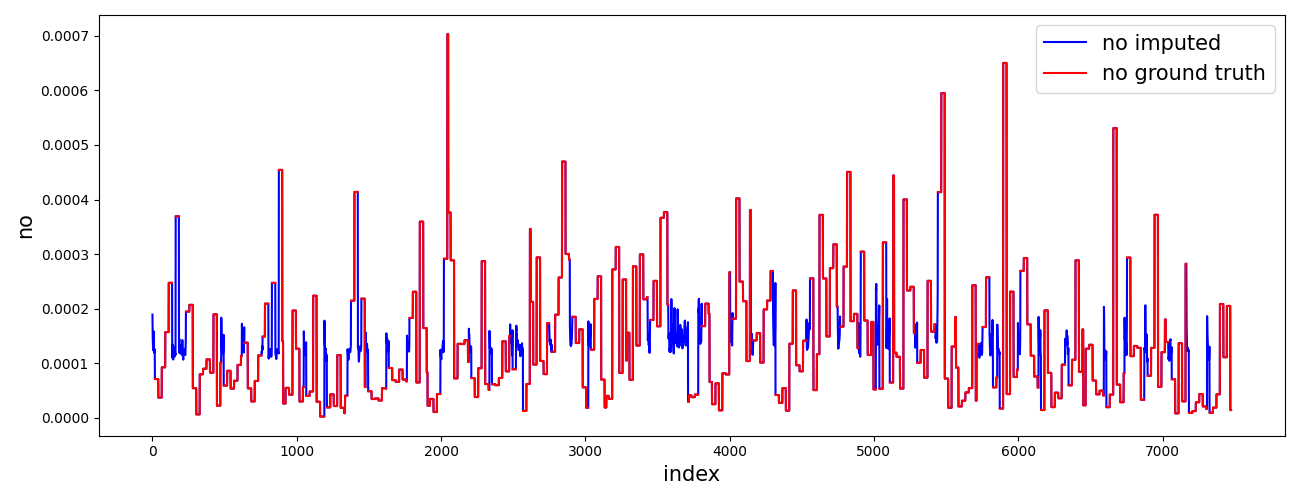


Handling for station 215



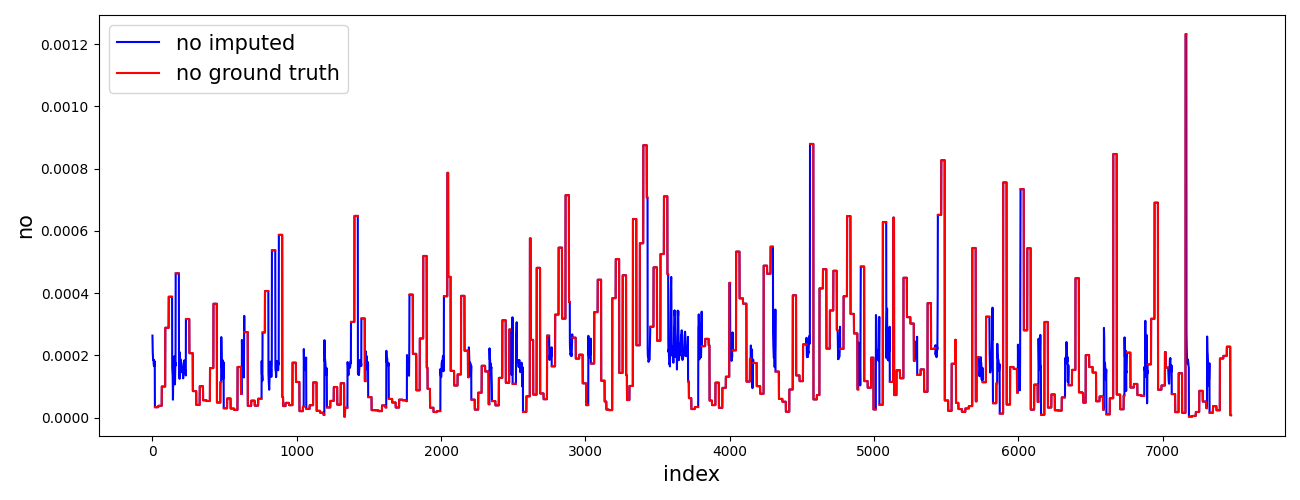


Handling for station 216



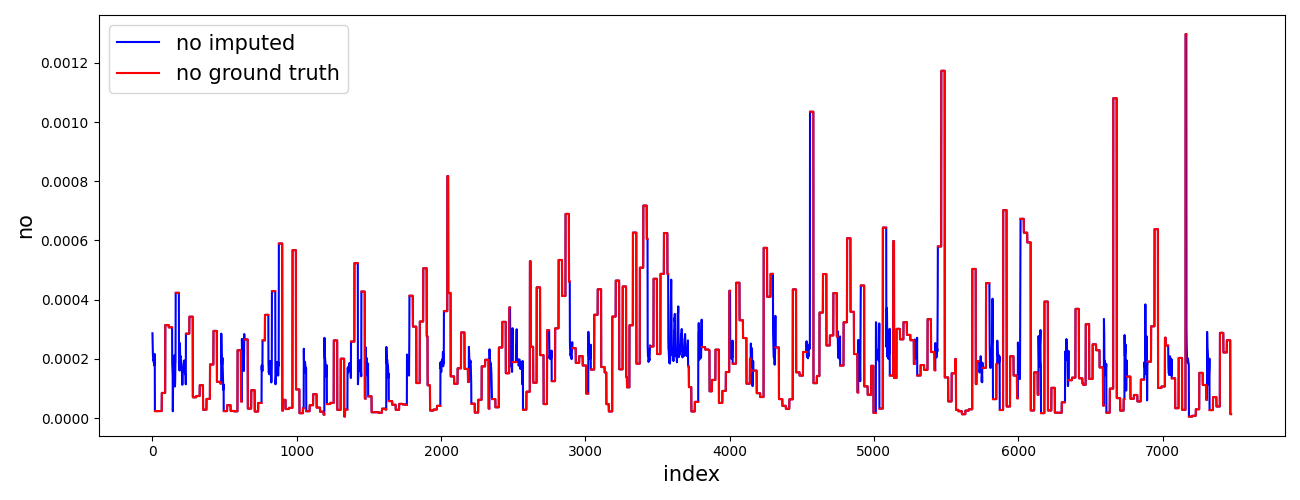

,pm25,pm10,o3,so2,no2,station,no
datetime,,,,,,,
2022-01-01 07:00:00,8.070718,28.069728,0.098301,0.000047,0.001115,201,0.000184
2022-01-01 08:00:00,9.922100,35.973360,0.078072,0.000062,0.001141,201,0.000162
2022-01-01 09:00:00,11.191617,40.858557,0.061198,0.000082,0.000941,201,0.000145
2022-01-01 10:00:00,11.655973,43.331055,0.050983,0.000087,0.000761,201,0.000134
2022-01-01 11:00:00,11.074831,39.380184,0.042117,0.000068,0.000600,201,0.000131
...,...,...,...,...,...,...,...
2022-12-31 01:00:00,9.481827,34.121409,0.026421,0.000149,0.002276,216,0.000013
2022-12-31 02:00:00,9.389163,34.542116,0.026171,0.000148,0.002208,216,0.000013
2022-12-31 03:00:00,9.472814,34.649932,0.026087,0.000151,0.002249,216,0.000013


In [10]:
all_stations_df = []

for station in sorted(df_cmaq_raw["station"].unique()):
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_cmaq_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]

    # Fill "aod" column
    df_cmaq_current_station_imputed = copy.deepcopy(df_cmaq_current_station)
    df_cmaq_current_station_imputed.loc[:, "no"] = mice(df_cmaq_current_station_imputed.drop(columns=["station"]))["no"]
    plot_2_data(data1=df_cmaq_current_station_imputed["no"],
               datalabel1="no imputed",
               data2=df_cmaq_current_station["no"],
               datalabel2="no ground truth",
               ylabel="no",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_cmaq_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_cmaq_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_cmaq_current_station_imputed)

# Merge all stations
df_cmaq = pd.concat(all_stations_df)
df_cmaq

### Extract datetime and station columns

In [11]:
# Get the time indices
cmaq_time_indices = df_cmaq.index
cmaq_time_indices

DatetimeIndex(['2022-01-01 07:00:00', '2022-01-01 08:00:00',
               '2022-01-01 09:00:00', '2022-01-01 10:00:00',
               '2022-01-01 11:00:00', '2022-01-01 12:00:00',
               '2022-01-01 13:00:00', '2022-01-01 14:00:00',
               '2022-01-01 15:00:00', '2022-01-01 16:00:00',
               ...
               '2022-12-30 20:00:00', '2022-12-30 21:00:00',
               '2022-12-30 22:00:00', '2022-12-30 23:00:00',
               '2022-12-31 00:00:00', '2022-12-31 01:00:00',
               '2022-12-31 02:00:00', '2022-12-31 03:00:00',
               '2022-12-31 04:00:00', '2022-12-31 05:00:00'],
              dtype='datetime64[ns]', name='datetime', length=52332, freq=None)

In [12]:
# Get the station column
cmaq_station_column = df_cmaq.loc[:, "station"]
cmaq_station_column

datetime
2022-01-01 07:00:00    201
2022-01-01 08:00:00    201
2022-01-01 09:00:00    201
2022-01-01 10:00:00    201
2022-01-01 11:00:00    201
                      ... 
2022-12-31 01:00:00    216
2022-12-31 02:00:00    216
2022-12-31 03:00:00    216
2022-12-31 04:00:00    216
2022-12-31 05:00:00    216
Name: station, Length: 52332, dtype: int64

### Split into features and labels
* Label: no
* Features: other columns

In [13]:
# Features with pm25_3km
cmaq_label = "no"
cmaq_feats = list(df_cmaq.columns)
cmaq_feats.remove(cmaq_label)
cmaq_feats.remove("station")

X_cmaq = df_cmaq.loc[:, cmaq_feats]
y_cmaq = df_cmaq.loc[:, [cmaq_label]]

In [14]:
X_cmaq

,pm25,pm10,o3,so2,no2
datetime,,,,,
2022-01-01 07:00:00,8.070718,28.069728,0.098301,0.000047,0.001115
2022-01-01 08:00:00,9.922100,35.973360,0.078072,0.000062,0.001141
2022-01-01 09:00:00,11.191617,40.858557,0.061198,0.000082,0.000941
2022-01-01 10:00:00,11.655973,43.331055,0.050983,0.000087,0.000761
2022-01-01 11:00:00,11.074831,39.380184,0.042117,0.000068,0.000600
...,...,...,...,...,...
2022-12-31 01:00:00,9.481827,34.121409,0.026421,0.000149,0.002276
2022-12-31 02:00:00,9.389163,34.542116,0.026171,0.000148,0.002208
2022-12-31 03:00:00,9.472814,34.649932,0.026087,0.000151,0.002249


In [15]:
y_cmaq

,no
datetime,
2022-01-01 07:00:00,0.000184
2022-01-01 08:00:00,0.000162
2022-01-01 09:00:00,0.000145
2022-01-01 10:00:00,0.000134
2022-01-01 11:00:00,0.000131
...,...
2022-12-31 01:00:00,0.000013
2022-12-31 02:00:00,0.000013
2022-12-31 03:00:00,0.000013


### Data normalization

In [16]:
# Scaled features
cmaq_features_scaler = MinMaxScaler()
X_cmaq_scaled = cmaq_features_scaler.fit_transform(X_cmaq)
X_cmaq_scaled = pd.DataFrame(X_cmaq_scaled, columns=X_cmaq.columns)
X_cmaq_scaled

,pm25,pm10,o3,so2,no2
0,0.027222,0.030401,0.798249,0.002360,0.014853
1,0.033520,0.038988,0.605661,0.003086,0.015207
2,0.037838,0.044296,0.445023,0.004108,0.012509
3,0.039418,0.046982,0.347769,0.004354,0.010063
4,0.037441,0.042690,0.263367,0.003422,0.007892
...,...,...,...,...,...
52327,0.032022,0.036976,0.113939,0.007443,0.030570
52328,0.031707,0.037433,0.111561,0.007392,0.029646
52329,0.031991,0.037550,0.110760,0.007548,0.030210
52330,0.034542,0.039138,0.113238,0.008329,0.036046


In [17]:
# Scaled label
cmaq_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_cmaq_scaled = cmaq_label_scaler.fit_transform(y_cmaq)
y_cmaq_scaled = pd.DataFrame(y_cmaq_scaled, columns=y_cmaq.columns)
y_cmaq_scaled

,no
0,0.141785
1,0.124603
2,0.111662
3,0.103283
4,0.101044
...,...
52327,0.010167
52328,0.010167
52329,0.010167
52330,0.010167


In [18]:
pd.concat((X_cmaq_scaled, y_cmaq_scaled), axis=1)\
    .set_index(cmaq_time_indices)\
    .to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], "quantrac_before_dim_reduction.csv"))

## Dimensionality Reduction

In [19]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': [],
 'mnbe': [],
 'r_coeff': [],
 'p_value': []}

### Model paramaters

In [20]:
#range_of_dimension = range(conf["reduction_cmaq"]["min_number_of_features"], X_cmaq_scaled.shape[1])
range_of_dimension = [2]
print(*range_of_dimension)

reduction_n_past, reduction_n_future = conf["reduction_cmaq"]["n_past"], conf["reduction_cmaq"]["n_future"]
reduction_epochs, reduction_batch_size = conf["reduction_cmaq"]["epochs"], conf["reduction_cmaq"]["batch_size"]
print(reduction_n_past, reduction_n_future, reduction_epochs, reduction_batch_size)

prediction_n_past = conf["prediction_cmaq"]["n_past"]
prediction_epochs, prediction_batch_size = conf["prediction_cmaq"]["epochs"], conf["prediction_cmaq"]["batch_size"]
print(prediction_n_past, prediction_epochs, prediction_batch_size)

saved_model_plot_dir = conf["workspace"]["saved_model_plot_dir"]
saved_model_weight_dir = conf["workspace"]["saved_model_weight_dir"]
print(saved_model_plot_dir, saved_model_weight_dir)

range_of_n_future = [24, 48, 72]
print(*range_of_n_future)

2
168 168 5 32
168 5 32
/le_thanh_van_118/workspace/hiep_workspace/saved_model_plot /le_thanh_van_118/workspace/hiep_workspace/saved_model_weight
24 48 72


### Prediction without reduction

In [21]:
'''
# Loop every n_future
for prediction_n_future in range_of_n_future
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    lstmpred = LSTMPrediction(X_cmaq_scaled, y_cmaq_scaled,
                                cmaq_label_scaler,
                                val_percentage=0.2, test_percentage=0.2,
                                n_past=prediction_n_past, n_future=prediction_n_future,
                                epochs=prediction_epochs, batch_size=prediction_batch_size,
                                verbose=1,
                                model_name=f"cmaq_{LSTMPrediction.class_name}_no_dim_reduction")
    lstmpred.dump(saved_model_plot_dir)
    all_days_inv_y_pred, all_days_inv_y_test, metrics, _ = lstmpred.execute(saved_model_weight_dir)

    # Visualize the prediction
    plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, prediction_n_future)
    
    # Print out the evaluation board
    evaluation_board['dim_reduction_method'] += ["None"]
    evaluation_board['dim_after_reduction'] += ["N/A"]
    evaluation_board['prediction'] += ["LSTM"]
    evaluation_board['n_future'] += [prediction_n_future]
    for m in LSTMPrediction.get_supported_metrics():
        evaluation_board[m] += [metrics[m][1]]

pd.DataFrame(evaluation_board)
'''

'\n# Loop every n_future\nfor prediction_n_future in range_of_n_future\n    print("\n" + "=" * 100 + "\n")\n    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")\n    lstmpred = LSTMPrediction(X_cmaq_scaled, y_cmaq_scaled,\n                                cmaq_label_scaler,\n                                val_percentage=0.2, test_percentage=0.2,\n                                n_past=prediction_n_past, n_future=prediction_n_future,\n                                epochs=prediction_epochs, batch_size=prediction_batch_size,\n                                verbose=1,\n                                model_name=f"cmaq_{LSTMPrediction.class_name}_no_dim_reduction")\n    lstmpred.dump(saved_model_plot_dir)\n    all_days_inv_y_pred, all_days_inv_y_test, metrics, _ = lstmpred.execute(saved_model_weight_dir)\n\n    # Visualize the prediction\n    plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, prediction_n_future)\n    \n    # Print out the evaluation board\n    evaluat

### Prediction + LSTM-Seq2Seq

#### Doing the loop



PREDICTION WITH N_FUTURE = 24

LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 359s 336ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 2/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 348s 332ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 3/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 351s 336ms/step - loss: nan - val_loss: nan
Epoch 4/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 346s 330ms/step - loss: nan - val_loss: nan
Epoch 5/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 347s 332ms/step - loss: nan - val_loss: nan
Restoring model weights from the end of the best epoch: 1.


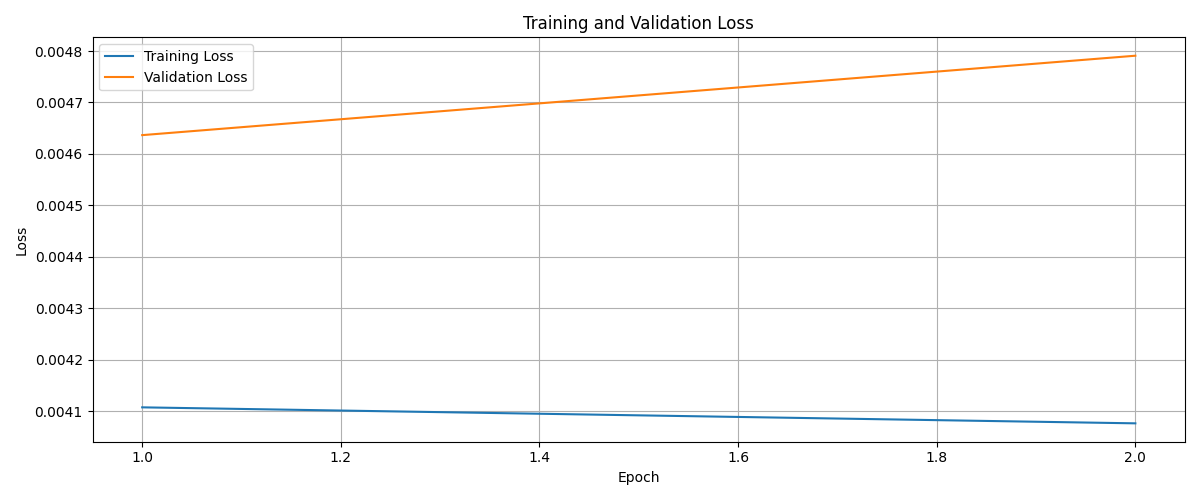

328/328 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - loss: 0.0052
LSTMSeq2SeqReduction.execute(): mae = 0.005159491207450628
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 63s 38ms/step


Model: "cmaq_LSTMSeq2SeqReduction_24_future_2_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 168, 100)  │     42,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50),      │     30,200 │ lstm[0][0]        │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        102 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 168, 2)    │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 168, 50)   │     10,600 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 168, 100)  │     60,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 168, 5)    │        505 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,623 (1.65 MB)

 Trainable params: 144,207 (563.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 288,416 (1.10 MB)

None


Model: "cmaq_LSTMSeq2SeqReduction_24_future_2_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 168, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 168, 100)       │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,702 (283.99 KB)

 Trainable params: 72,702 (283.99 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "cmaq_LSTMPrediction_24_future_with_LSTMSeq2SeqReduction_2_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 168, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 64),      │     17,408 │ input_layer_2[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 24, 64)    │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 24, 64)    │     33,024 │ repeat_vector_1[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 24, 1)     │         65 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 89s 83ms/step - loss: 0.0070 - val_loss: 0.0120
Epoch 2/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - loss: 0.0064 - val_loss: 0.0116
Epoch 3/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - loss: 0.0063 - val_loss: 0.0117
Epoch 4/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - loss: 0.0062 - val_loss: 0.0115
Epoch 5/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - loss: 0.0061 - val_loss: 0.0115
Restoring model weights from the end of the best epoch: 5.


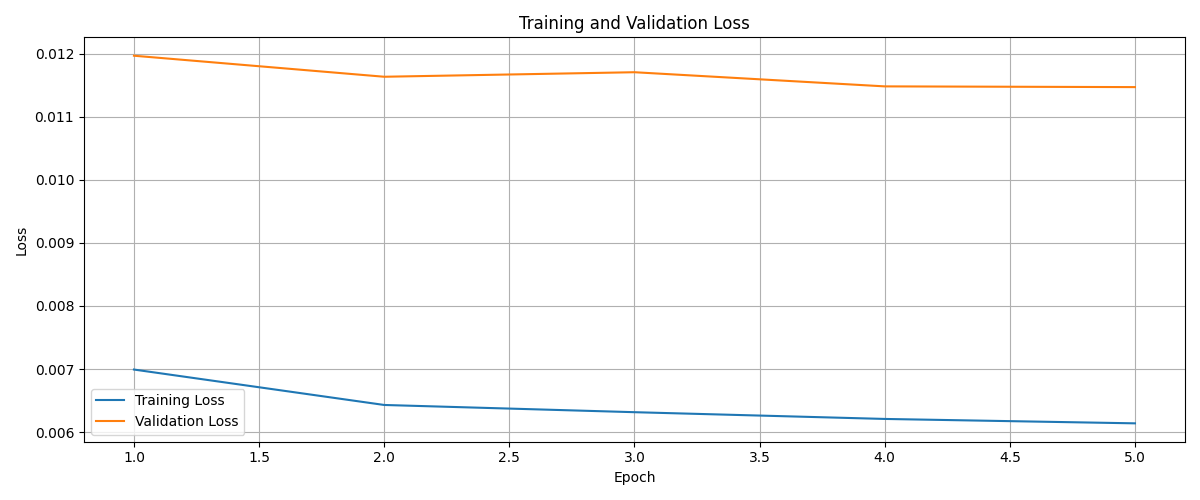

326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
y_pred.shape = (10428, 24, 1)
y_test.shape = (10428, 24, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (10428, 24), inv_y_test.shape = (10428, 24)
Day 1:
	mae = 3.652642562967736e-05
	mse = 4.424047402539421e-09
	rmse = 6.65135129318804e-05
	r2 = 0.8283276794368177
	mape = 0.2656724719541375
	mnbe = 4.642805453468525
	r_coeff = 0.9447837217054542
	p_value = 0.0
Day 2:
	mae = 4.3663950276573215e-05
	mse = 7.0654669078106015e-09
	rmse = 8.405633175323916e-05
	r2 = 0.7441680198232086
	mape = 0.3106004322747004
	mnbe = 8.865114086661057
	r_coeff = 0.9039683052108186
	p_value = 0.0
Day 3:
	mae = 5.269801151136236e-05
	mse = 9.724634782196746e-09
	rmse = 9.86135628714263e-05
	r2 = 0.6209064798359765
	mape = 0.3532286410407405
	mnbe = 8.487168320634431
	r_coeff = 0.8620032941186438
	p_value = 0.0
Day 4:
	mae = 6.139404057374655e-05
	mse = 1.2182448339799423

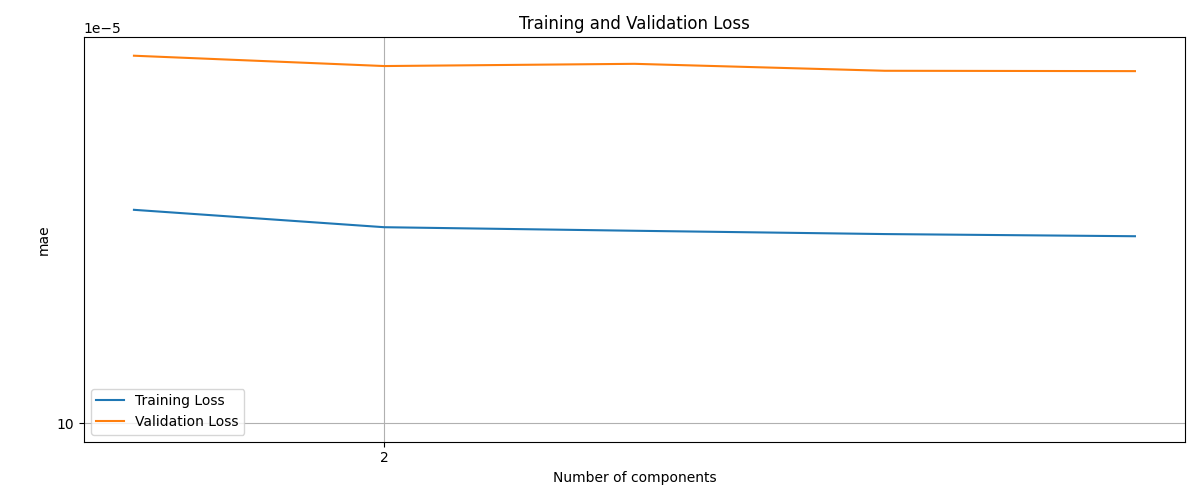

inv_y_pred.shape = (10428, 24)
inv_y_test.shape = (10428, 24)


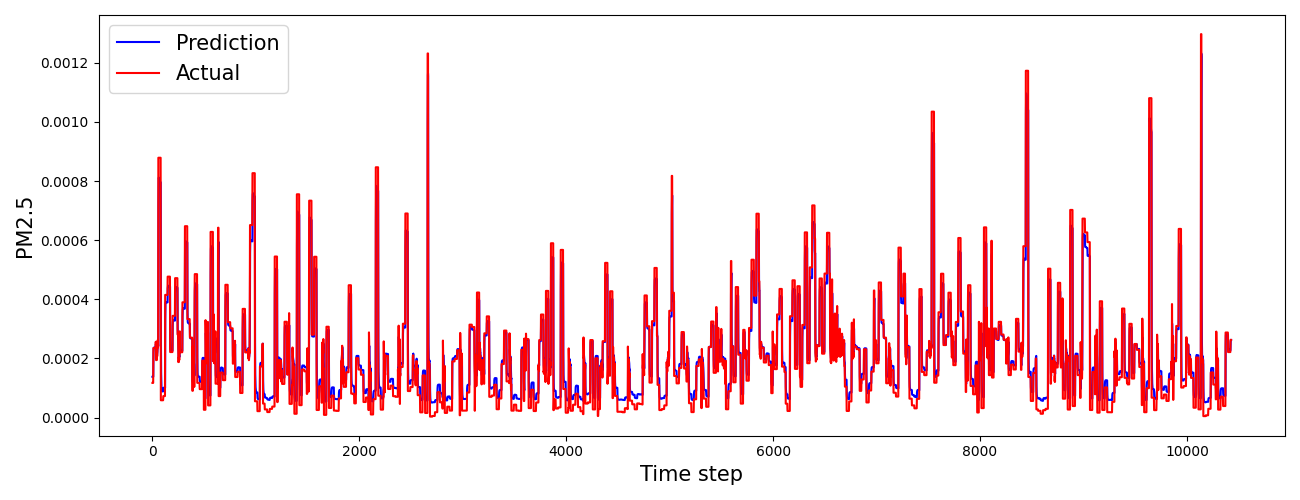



PREDICTION WITH N_FUTURE = 48

LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 357s 333ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 2/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 347s 331ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 3/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 346s 330ms/step - loss: nan - val_loss: nan
Epoch 4/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 348s 333ms/step - loss: nan - val_loss: nan
Epoch 5/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 348s 332ms/step - loss: nan - val_loss: nan
Restoring model weights from the end of the best epoch: 1.


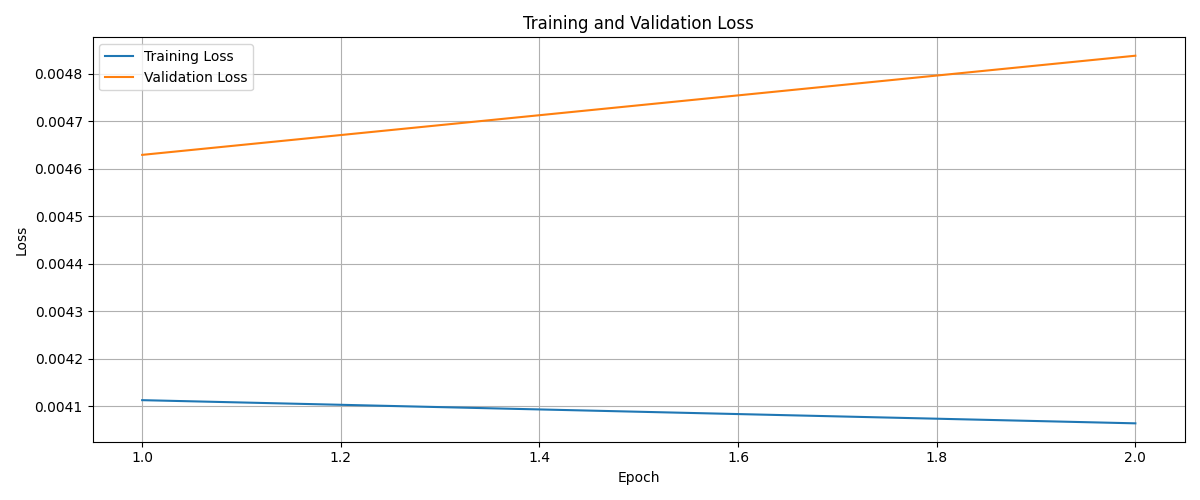

328/328 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - loss: 0.0052
LSTMSeq2SeqReduction.execute(): mae = 0.005159425549209118
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 63s 39ms/step


Model: "cmaq_LSTMSeq2SeqReduction_48_future_2_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 168, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 168, 100)  │     42,400 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_6[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        102 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 168, 2)    │          0 │ dense_3[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 168, 50)   │     10,600 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 168, 100)  │     60,400 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 168, 5)    │        505 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,623 (1.65 MB)

 Trainable params: 144,207 (563.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 288,416 (1.10 MB)

None


Model: "cmaq_LSTMSeq2SeqReduction_48_future_2_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 168, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 168, 100)       │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,702 (283.99 KB)

 Trainable params: 72,702 (283.99 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "cmaq_LSTMPrediction_48_future_with_LSTMSeq2SeqReduction_2_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 168, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 64),      │     17,408 │ input_layer_5[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 48, 64)    │          0 │ lstm_10[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 48, 64)    │     33,024 │ repeat_vector_3[… │
│                     │                   │            │ lstm_10[0][1],    │
│                     │                   │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 64)    │          0 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 48, 1)     │         65 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 97s 90ms/step - loss: 0.0085 - val_loss: 0.0151
Epoch 2/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 93s 89ms/step - loss: 0.0081 - val_loss: 0.0150
Epoch 3/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 94s 90ms/step - loss: 0.0079 - val_loss: 0.0149
Epoch 4/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 93s 89ms/step - loss: 0.0079 - val_loss: 0.0148
Epoch 5/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 92s 88ms/step - loss: 0.0078 - val_loss: 0.0148
Restoring model weights from the end of the best epoch: 5.


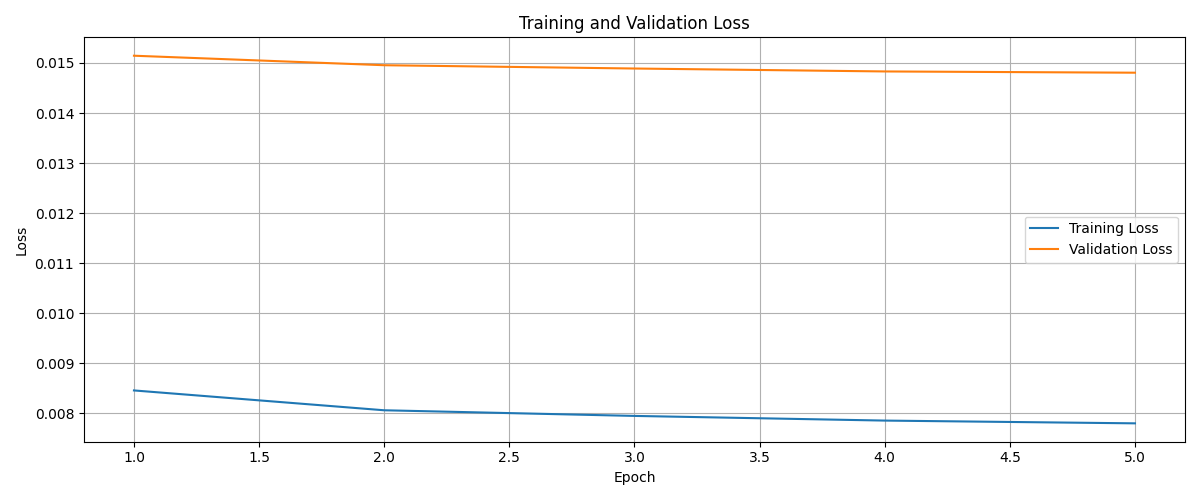

326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
y_pred.shape = (10423, 48, 1)
y_test.shape = (10423, 48, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (10423, 48), inv_y_test.shape = (10423, 48)
Day 1:
	mae = 5.0056746622696024e-05
	mse = 5.755106165226252e-09
	rmse = 7.58624160255014e-05
	r2 = 0.7629043845668937
	mape = 0.3188857397923398
	mnbe = 14.147184313740494
	r_coeff = 0.9388747408638424
	p_value = 0.0
Day 2:
	mae = 5.753379077110679e-05
	mse = 8.369860872720732e-09
	rmse = 9.148694372816666e-05
	r2 = 0.684090680252887
	mape = 0.3516470565559866
	mnbe = 16.92175984328477
	r_coeff = 0.898224408498728
	p_value = 0.0
Day 3:
	mae = 6.285433977506841e-05
	mse = 1.0725911002864278e-08
	rmse = 0.00010356597415591802
	r2 = 0.5704472734869148
	mape = 0.3762906621463766
	mnbe = 15.309354554263905
	r_coeff = 0.8573953469722452
	p_value = 0.0
Day 4:
	mae = 6.801034841009017e-05
	mse = 1.28292586723285

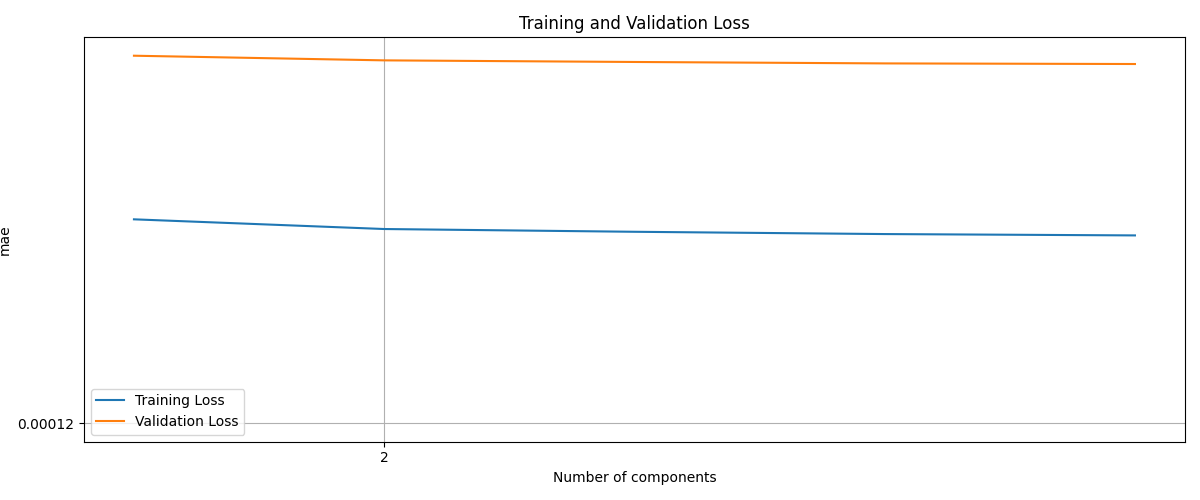

inv_y_pred.shape = (10423, 48)
inv_y_test.shape = (10423, 48)


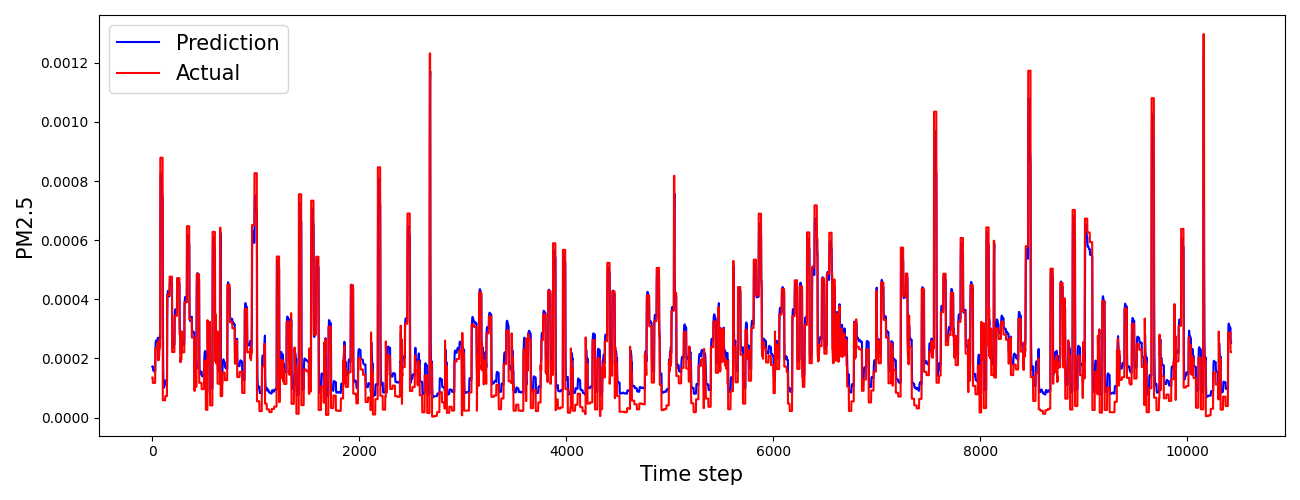



PREDICTION WITH N_FUTURE = 72

LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 361s 337ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 2/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 352s 336ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 3/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 354s 338ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 4/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 348s 333ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 5/5
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 348s 332ms/step - loss: 0.0037 - val_loss: 0.0046
Restoring model weights from the end of the best epoch: 4.


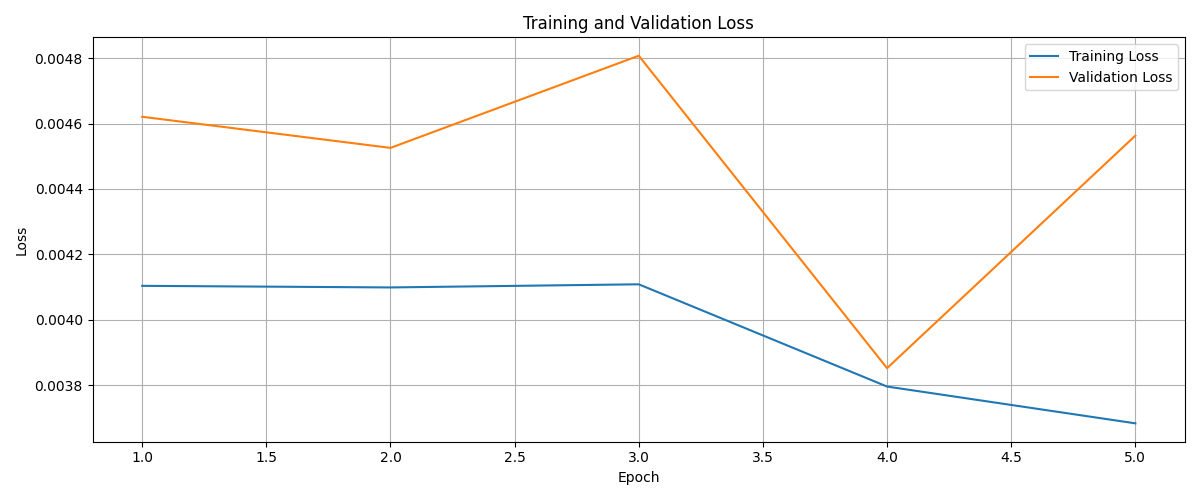

328/328 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - loss: 0.0044
LSTMSeq2SeqReduction.execute(): mae = 0.004401953425258398
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step


Model: "cmaq_LSTMSeq2SeqReduction_72_future_2_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 168, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 168, 100)  │     42,400 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_12[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │        102 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 168, 2)    │          0 │ dense_6[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 168, 50)   │     10,600 │ repeat_vector_4[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 168, 100)  │     60,400 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 168, 5)    │        505 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,623 (1.65 MB)

 Trainable params: 144,207 (563.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 288,416 (1.10 MB)

None


Model: "cmaq_LSTMSeq2SeqReduction_72_future_2_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 168, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 168, 100)       │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,702 (283.99 KB)

 Trainable params: 72,702 (283.99 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "cmaq_LSTMPrediction_72_future_with_LSTMSeq2SeqReduction_2_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 168, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ [(None, 64),      │     17,408 │ input_layer_8[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 72, 64)    │          0 │ lstm_16[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 72, 64)    │     33,024 │ repeat_vector_5[… │
│                     │                   │            │ lstm_16[0][1],    │
│                     │                   │            │ lstm_16[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 72, 64)    │          0 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 72, 1)     │         65 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 110s 101ms/step - loss: 0.0090 - val_loss: 0.0164
Epoch 2/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 105s 101ms/step - loss: 0.0086 - val_loss: 0.0163
Epoch 3/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 104s 100ms/step - loss: 0.0085 - val_loss: 0.0164
Epoch 4/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 104s 100ms/step - loss: 0.0085 - val_loss: 0.0164
Epoch 5/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 103s 99ms/step - loss: 0.0084 - val_loss: 0.0163
Restoring model weights from the end of the best epoch: 2.


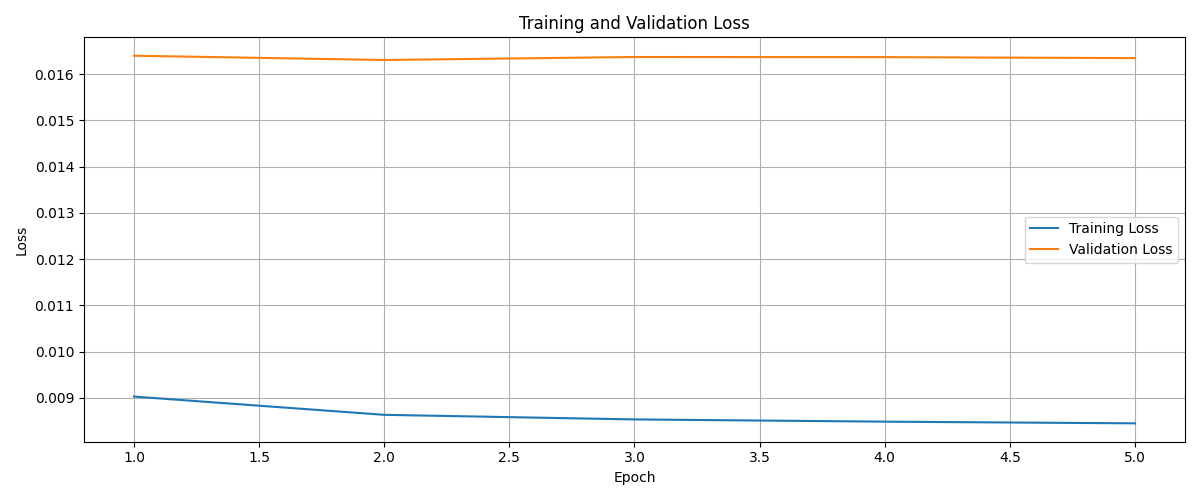

326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
y_pred.shape = (10419, 72, 1)
y_test.shape = (10419, 72, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (10419, 72), inv_y_test.shape = (10419, 72)
Day 1:
	mae = 6.485253158537732e-05
	mse = 7.985363102803699e-09
	rmse = 8.93608588969673e-05
	r2 = 0.6687007100222713
	mape = 0.36452083075525293
	mnbe = 19.1988932417812
	r_coeff = 0.9138151536311474
	p_value = 0.0
Day 2:
	mae = 7.476182006607284e-05
	mse = 1.112757437252447e-08
	rmse = 0.00010548731853888632
	r2 = 0.58554397227417
	mape = 0.39790705469306364
	mnbe = 23.483821476983348
	r_coeff = 0.8718824217785228
	p_value = 0.0
Day 3:
	mae = 7.926635566763138e-05
	mse = 1.3353612174275286e-08
	rmse = 0.00011555783043253835
	r2 = 0.47062403182962953
	mape = 0.4175445032232928
	mnbe = 22.172312558724293
	r_coeff = 0.831990288021953
	p_value = 0.0
Day 4:
	mae = 8.160795891446593e-05
	mse = 1.4967585758159

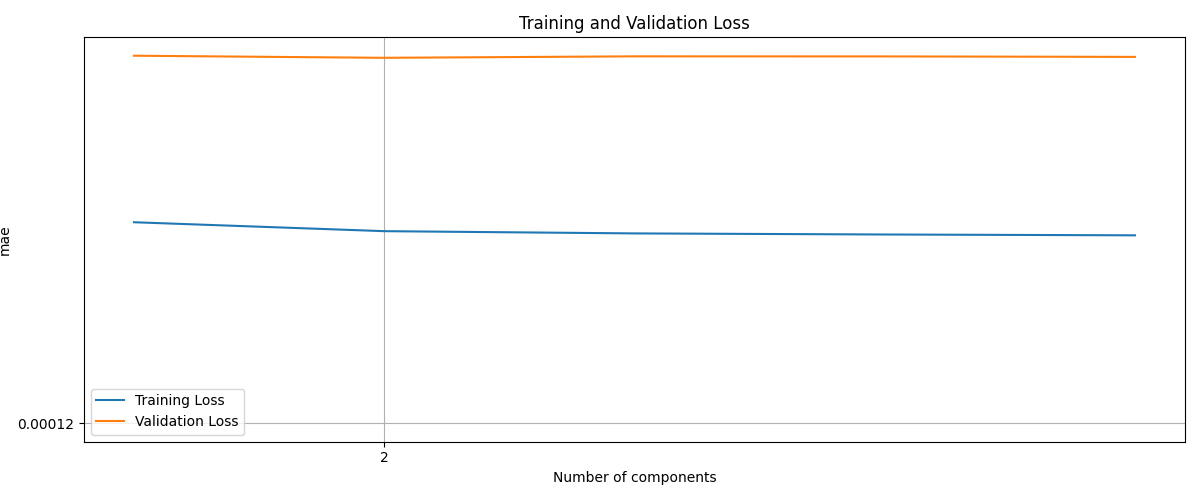

inv_y_pred.shape = (10419, 72)
inv_y_test.shape = (10419, 72)


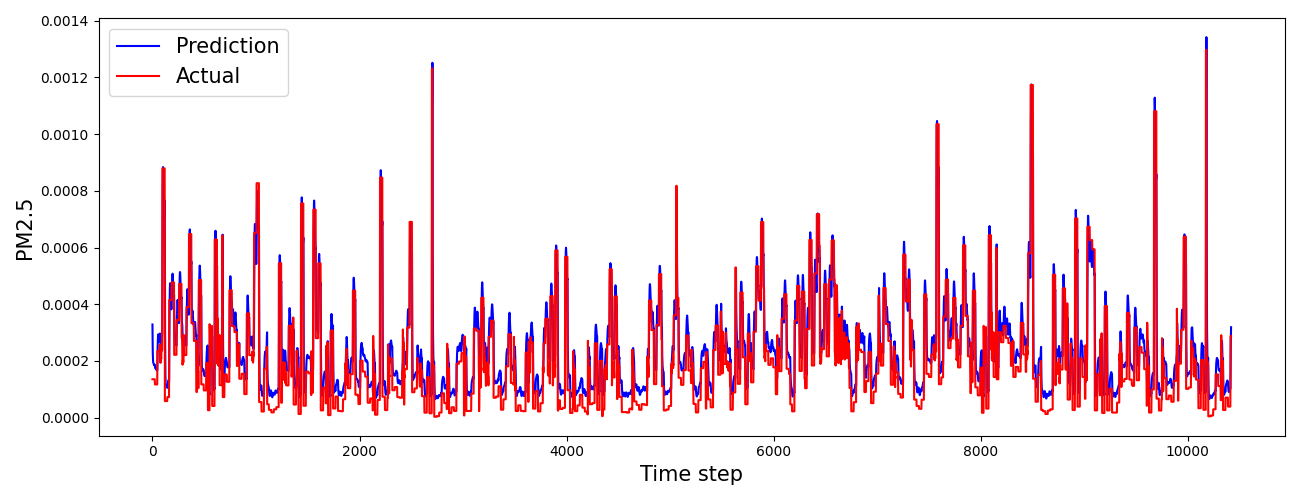

,dim_reduction_method,dim_after_reduction,prediction,mae,mse,rmse,r2,mape,mnbe,r_coeff,p_value
0,LSTM-Seq2Seq,2,LSTM,0.000099,2.427247e-08,0.000152,-2.805285,0.578348,-4.796829,0.551476,2.782371e-89
1,LSTM-Seq2Seq,2,LSTM,0.000117,3.077509e-08,0.000173,-25.248084,0.680247,-10.938063,0.365529,2.038143e-45
2,LSTM-Seq2Seq,2,LSTM,0.000124,3.374060e-08,0.000182,-75.810820,0.730075,-14.077033,0.278360,6.082735e-24


In [22]:
# Loop every n_future
lstms2s_n_future_mapper = {}

for prediction_n_future in range_of_n_future:
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    # Prediction
    loopresults = generate_loopresults(X_cmaq_scaled, y_cmaq_scaled,
                                       cmaq_label_scaler,
                                       range_of_dimension,
                                       LSTMSeq2SeqReduction,
                                       LSTMPrediction,
                                       "cmaq", "cmaq",
                                       reduction_n_past, reduction_n_future,
                                       reduction_epochs, reduction_batch_size,
                                       prediction_n_past, prediction_n_future,
                                       prediction_epochs, prediction_batch_size,
                                       saved_model_weight_dir, saved_model_plot_dir)
    best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, metric_to_choose="mae")
    
    # Print out the evaluation board
    evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
    evaluation_board['dim_after_reduction'] += [best_num_of_components]
    evaluation_board['prediction'] += ["LSTM"]
    for metric, value in best_metrics.items():
        evaluation_board[metric] += [value]

    # Update n_future mapper
    lstms2s_n_future_mapper[prediction_n_future] = (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path)

pd.DataFrame(evaluation_board)

In [23]:
stophere

NameError: name 'stophere' is not defined

#### Predict all from reduced data

In [ ]:
# Inference LSTM
pred_no_cmaq_from_lstms2s_reduced = inferenceLSTM(best_encoded_data, y_cmaq_scaled,
                                                    prediction_n_past, prediction_n_future,
                                                    best_prediction_model_path, verbose=1)
inv_pred_no_lstms2s_reduced = cmaq_label_scaler.inverse_transform(pred_no_cmaq_from_lstms2s_reduced.reshape(-1, 1))
print(inv_pred_no_lstms2s_reduced.shape)
print(inv_pred_no_lstms2s_reduced)

# Visualization
print(inv_pred_no_lstms2s_reduced.shape)
print(y_cmaq.shape)
plot_2_data(data1=y_cmaq.head(2000),
           datalabel1="actual values",
           data2=inv_pred_no_lstms2s_reduced[:2000],
           datalabel2="predicted values",
           ylabel="time",
           xlabel="no")

### Prediction + GRU-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = generate_loopresults(X_cmaq_scaled, y_cmaq_scaled,
                                   cmaq_label_scaler,
                                   range_of_dimension,
                                   GRUSeq2SeqReduction,
                                   LSTMPrediction,
                                   "cmaq", "cmaq",
                                   reduction_n_past, reduction_n_future,
                                   reduction_epochs, reduction_batch_size,
                                   prediction_n_past, prediction_n_future,
                                   prediction_epochs, prediction_batch_size,
                                   saved_model_weight_dir, saved_model_plot_dir)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Predict all from reduced data

In [ ]:
# Inference LSTM
pred_no_cmaq_from_grus2s_reduced = inferenceLSTM(best_encoded_data, y_cmaq_scaled,
                                                    prediction_n_past, prediction_n_future,
                                                    best_prediction_model_path, verbose=1)
inv_pred_no_grus2s_reduced = cmaq_label_scaler.inverse_transform(pred_no_cmaq_from_grus2s_reduced.reshape(-1, 1))
print(inv_pred_no_grus2s_reduced.shape)
print(inv_pred_no_grus2s_reduced)

# Visualization
print(inv_pred_no_grus2s_reduced.shape)
print(y_cmaq.shape)
plot_2_data(data1=y_cmaq.head(2000),
           datalabel1="actual values",
           data2=inv_pred_no_grus2s_reduced[:2000],
           datalabel2="predicted values",
           ylabel="time",
           xlabel="no")

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = generate_loopresults(X_cmaq_scaled, y_cmaq_scaled,
                                   cmaq_label_scaler,
                                   range_of_dimension,
                                   CNNLSTMSeq2SeqReduction,
                                   LSTMPrediction,
                                   "cmaq", "cmaq",
                                   reduction_n_past, reduction_n_future,
                                   reduction_epochs, reduction_batch_size,
                                   prediction_n_past, prediction_n_future,
                                   prediction_epochs, prediction_batch_size,
                                   saved_model_weight_dir, saved_model_plot_dir)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Predict all from reduced data

In [ ]:
# Inference LSTM
pred_no_cmaq_from_cnnlstms2s_reduced = inferenceLSTM(best_encoded_data, y_cmaq_scaled,
                                                    prediction_n_past, prediction_n_future,
                                                    best_prediction_model_path, verbose=1)
inv_pred_no_cnnlstms2s_reduced = cmaq_label_scaler.inverse_transform(pred_no_cmaq_from_cnnlstms2s_reduced.reshape(-1, 1))
print(inv_pred_no_cnnlstms2s_reduced.shape)
print(inv_pred_no_cnnlstms2s_reduced)

# Visualization
print(inv_pred_no_cnnlstms2s_reduced.shape)
print(y_cmaq.shape)
plot_2_data(data1=y_cmaq.head(2000),
           datalabel1="actual values",
           data2=inv_pred_no_cnnlstms2s_reduced[:2000],
           datalabel2="predicted values",
           ylabel="time",
           xlabel="no")